<a href="https://colab.research.google.com/github/annesofiedahl/M2-Exam/blob/main/M2_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Definition of a problem statement and a short outline of the implementation


**"*How accurately can ratings of Post Nords trustpilot reviews be predicted, and are there common words, topics or patterns in the reviews (and reviewers), hereof bad reviews specifically?*"** 

To answer the question, LDA modelling (UML) will be used to identify topics within the total amount reviews, and bad reviews (reviews with low rating) specifically. 

Afterwards, different classifiers (and vectorizers) will be used to predict the ratings of reviews, based on the review text. 

Additionally, a network of 1000 reviewers will be made, in order to uncover if Post Nords reviewers, reviews the same businesses (*eg. GLS or DAO*)

### 2. Description of data acquisition / how it was collected (by you or the publisher of the data)

The dataset has been created based on a webscraping of PostNords trustpilot page. Thus, 400.000 (of approx. 700.000) danish reviews have been collected. The data was collected using requests and scrapy, and contains; *name/username of the reviewer, the total amount of reviews made by the reviewer, the reviewers profile url, date, location, rating, review header & review text.*

Due to computation limitations (*eg. numpy core memory requirement*), it has been decided to only use 50.000 of the collected reviews, however, the remaining are available;

https://raw.githubusercontent.com/NicklasStiborg/M2Exam/main/trustpilot_reviews_200k_1.csv?token=AOUWZYJB2YO7CNOE2HVYEE3BRAFIQ
https://raw.githubusercontent.com/NicklasStiborg/M2Exam/main/trustpilot_reviews_200k_2.csv?token=AOUWZYKUAJ2TQQQ2WGENQALBRAGXA

In addition, the webscraping scripts can be accessed through;

https://raw.githubusercontent.com/NicklasStiborg/M2Exam/main/webscraping.py?token=AOUWZYJTFPVCEDAHQIWNRL3BRAI6K

Furthermore, there have been collected 1000 profiles' list of reviews, containing; *name/username of the reviewer, the reviewers profile url & list of pages reviewed.* The reason for the smaller numbers of profiles collected, in comparison to reviews, is the due to Trustpilots scraping policy (https://www.trustpilot.com/robots.txt). However, it is important to point out that even though only 1000 profiles have been collected, each profile can, in theory, have an unlimited amount of reviews, making the amount of edges in the network significant. 

### 3. Data preparation (general) 
Due to the data being collected, rather than obtain through third party, the data structure has been determined, and thus no major data preparation will be neeeded.
However, a minor error in the values of the date column, have been found after the data collection, resulting in a small cleaning of the data. Furthermore, not all the reviews contains a review text, but some only a header text, resulting in a NaN values, which will be dropped from the dataframe. Alternatively, dummy values could be created and be subsetted, however the amount of data justifies the dropping of NaN values. 

#### 3.1 Library imports

In [ ]:
!pip install pyLDAvis
!pip install lemmy

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from itertools import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import LdaMulticore
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from nltk import word_tokenize
import lemmy
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from gensim.models import Word2Vec
import networkx as nx
import community as community_louvain
import warnings
warnings.filterwarnings("ignore")
csfont = {'fontname':'Times New Roman'}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#reading and creating df
df = pd.read_csv("https://raw.githubusercontent.com/NicklasStiborg/M2Exam/main/trustpilot_reviews_200k_1.csv?token=GHSAT0AAAAAABVK2AKJ5MZNAPFXUYOTMHTKYWFXBLA")

#only use 50000 due to computation limits
df = df[:50000]

#dropping nan values
df = df.dropna()

#cleaning date column
df["date"] = [i[:10] for i in df["date"]]

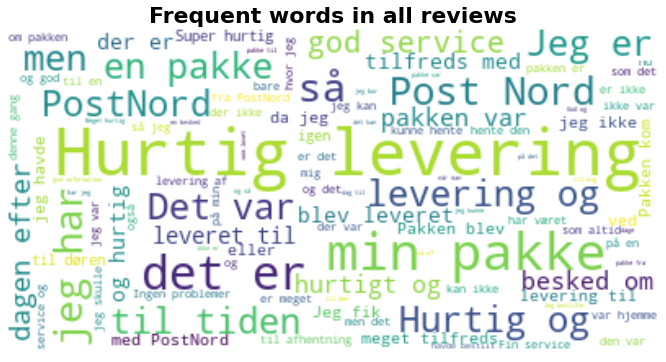

In [ ]:
#wordcloud for all reviews
text = " ".join([i for i in df['text']])
wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.title("Frequent words in all reviews", fontsize=22, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear", cmap="Blues")
plt.axis("off")
plt.show()

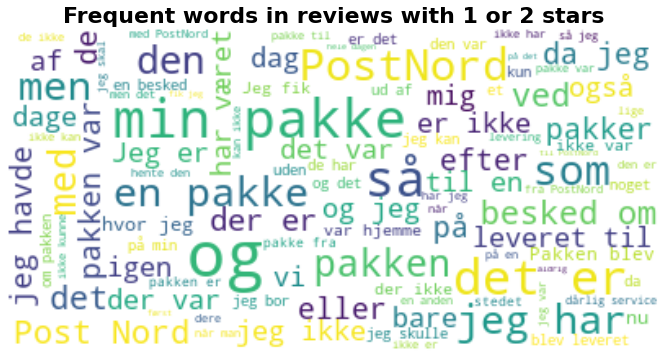

In [ ]:
#wordcloud for reviews with 1 or 2 stars
text = " ".join([i for i in df['text'][df['rating'] <= 2]])
wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.title("Frequent words in reviews with 1 or 2 stars", fontsize=22, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear", cmap="Blues")
plt.axis("off")
plt.show()

#### 3.2 Text cleaning

In order to clean the text for NLP purposes, the review texts, will be processed in terms of *lowering, filtering (discarding digits), removal of punctuations and lemmatization*. Moreover, stopwords will be removed, in order to get a 'pure text'. Since this is danish text, the built-in lemmatizers and stopwords in nltk & gensim cannot be used, resulting in the use of lemmy (danish lemmatizer), and the following stop words list.

In [ ]:
stopwordsDA = [
"ad","af","aldrig","alene","alle","allerede","alligevel","alt","altid","anden","andet",
"andre","at","bag","bare","begge","bl", "bl.a.","blandt","blev","blive","bliver","burde","bør",
"ca", "ca.","da","de","dem","den","denne","dens","der","derefter","deres","derfor","derfra",
"deri","dermed","derpå","derved","det","dette","dig","din","dine","disse","dit","dog","du",
"efter","egen","ej","eks", "eller","ellers","en","end","endnu","ene","eneste","enhver","ens",
"enten","er","et","f.eks.","far","fem","fik","fire","flere","flest","fleste","for",
"foran","fordi","forrige","fra","fx","få","får","før","først","gennem","gjorde","gjort",
"god","godt","gør","gøre","gørende","ham","han","hans","har","havde","have","hej","hel",
"heller","helt","hen","hende","hendes","henover","her","herefter","heri","hermed","herpå",
"hos","hun","hvad","hvem","hver","hvilke","hvilken","hvilkes","hvis","hvor","hvordan",
"hvorefter","hvorfor","hvorfra","hvorhen","hvori","hvorimod","hvornår","hvorved","i",
"igen","igennem","ikke","imellem","imens","imod","ind","indtil","ingen","intet","ja",
"jeg","jer","jeres","jo","kan","kom","komme","kommer","kun","kunne","lad","langs","lav",
"lave","lavet","lidt","lige","ligesom","lille","længere","man","mand","mange","med",
"meget","mellem","men","mens","mere","mest","mig","min","mindre","mindst","mine","mit",
"mod","må","måske","ned","nej","nemlig","ni","nogen","nogensinde","noget","nogle","nok",
"nu","ny","nyt","når","nær","næste","næsten","og","også","okay","om","omkring","op","os",
"otte","over","overalt","pga", "pga.","på","samme","sammen","se","seks","selv","selvom","senere",
"ser","ses","siden","sig","sige","sin","sine","sit","skal","skulle","som","stadig","stor",
"store","synes","syntes","syv","så","sådan","således","tag","tage","temmelig","thi","ti",
"tidligere","til","tilbage","tit","to","tre","ud","uden","udover","under","undtagen","var",
"ved","vi","via","vil","ville","vor","vore","vores","vær","være","været","øvrigt"]

##### 3.2.1 Lowering and filtering

In [ ]:
def regText(text):
    return " ".join(re.sub("[^a-zA-ZÆØÅæøå]", " ",text.lower()).split())
df['text'] = df['text'].apply(regText)

##### 3.2.2 Removing punctuation 

In [ ]:
df['text'] = [i.strip(r'[" ,.!?:;"]') for i in df['text']]

##### 3.2.3 Removing stopwords

In [ ]:
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwordsDA]))

##### 3.2.4 Lemmatizing

In [ ]:
lemmatizer = lemmy.load("da")
df['text'] = [lemmatizer.lemmatize("",i)[0] for i in df['text']]

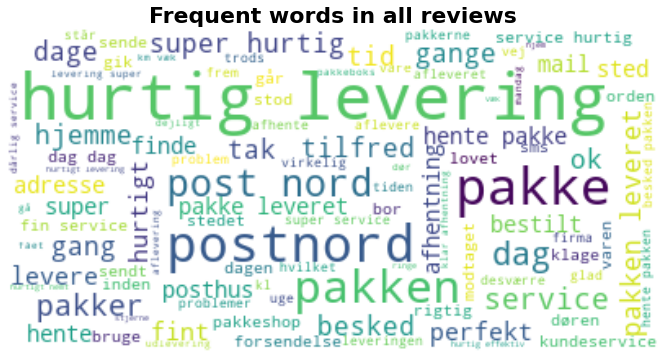

In [ ]:
#wordcloud for all reviews
text = " ".join([i for i in df['text']])
wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.title("Frequent words in all reviews", fontsize=22, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear", cmap="Blues")
plt.axis("off")
plt.show()

As shown above in the wordcloud, *pakke* (package) appears in multiple forms (*eg. pakken* (the package)). As also shown, the imported lemmatizer does not account for this, and since the word is so frequent in the dataset, further lemmitization will be used.

In [ ]:
def lemmatizerPckge(sen):
    if "pakkerne" in sen:
        sen1= sen.replace("pakkerne", "pakke")
        return sen1 
    elif "pakker" in sen:
        sen1= sen.replace("pakker", "pakke")
        return sen1
    elif "pakken" in sen:
        sen1= sen.replace("pakken", "pakke")
        return sen1
    else:
        return sen
    
df['text'] = [lemmatizerPckge(i) for i in df['text']]

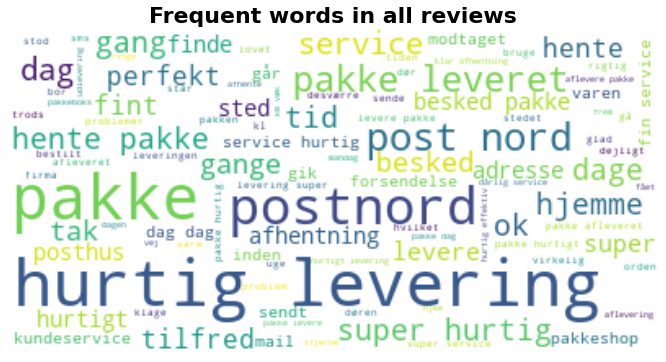

In [ ]:
#wordcloud for all reviews
text = " ".join([i for i in df['text']])
wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.title("Frequent words in all reviews", fontsize=22, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear", cmap="Blues")
plt.axis("off")
plt.show()

### 4. Data summary

As previously mentioned, the dataframe consists of 7 features:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28378 entries, 1 to 49999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   28378 non-null  int64 
 1   name         28378 non-null  object
 2   profileLink  28378 non-null  object
 3   date         28378 non-null  object
 4   rating       28378 non-null  int64 
 5   reviewCount  28378 non-null  int64 
 6   header       28378 non-null  object
 7   text         28378 non-null  object
dtypes: int64(3), object(5)
memory usage: 1.9+ MB


##### 4.2.1 Distribution of ratings

Text(0, 0.5, 'Reviews')

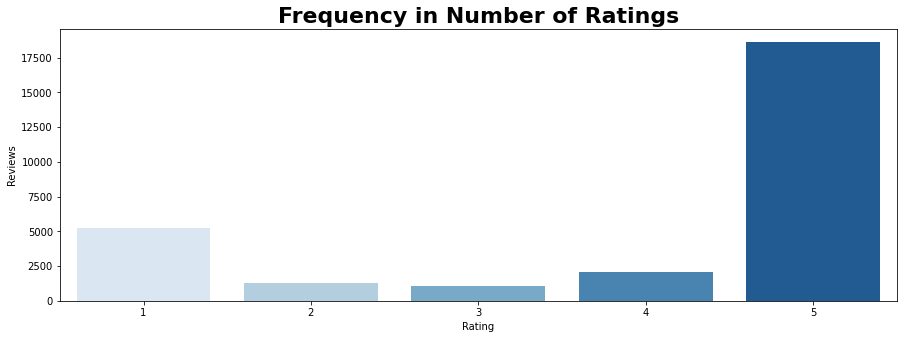

In [ ]:
ratingCounts = df.rating.value_counts()
plt.figure(figsize=(15,5))
plt.title("Frequency in Number of Ratings", fontsize=22, fontweight="bold")
sns.barplot(x=ratingCounts.index, y=ratingCounts.values, palette = 'Blues')
plt.xlabel('Rating')
plt.ylabel('Reviews')

##### 4.2.2 Amount of reviews per user

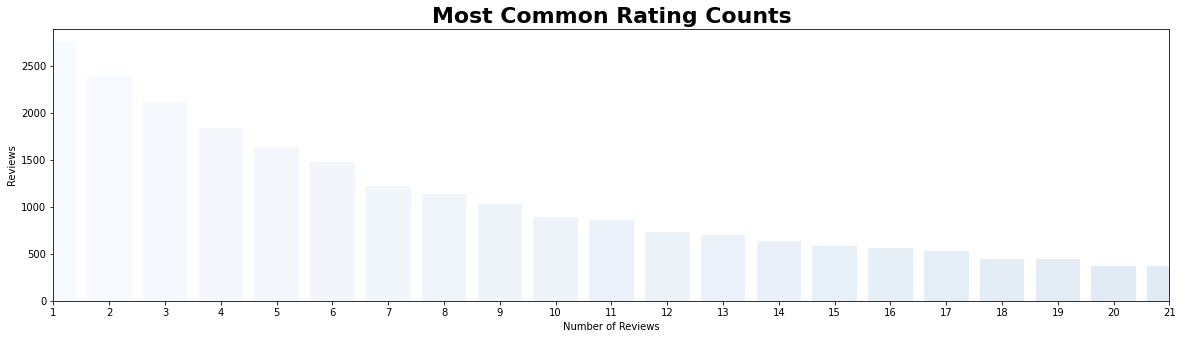

In [ ]:
reviewCounts = df.reviewCount.value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x=reviewCounts.index, y=reviewCounts.values, palette="Blues", alpha = 1)
plt.xlim(0,20)
plt.xlabel("Number of Reviews")
plt.ylabel("Reviews")
plt.title("Most Common Rating Counts", fontsize=22, fontweight="bold",);

Furthermore, users with negative ratings (of 1), tends to have less reviews;

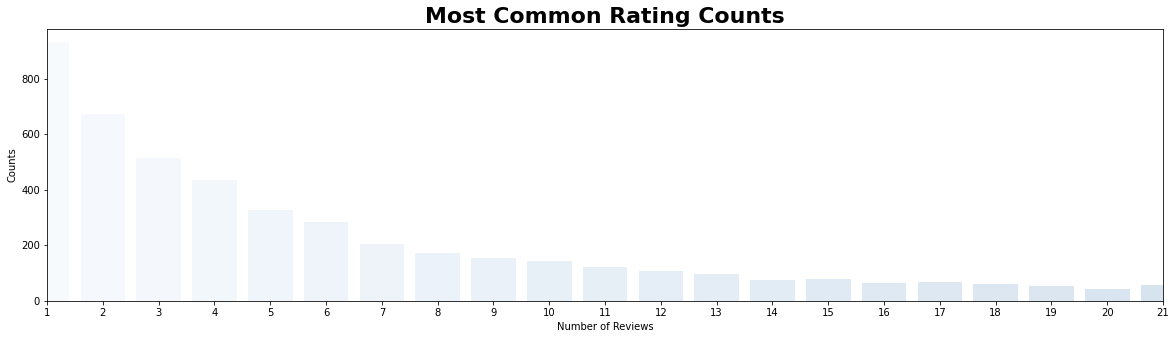

In [ ]:
dfRating1 =  df[df['rating']==1]
reviewCounts1 = dfRating1.reviewCount.value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x=reviewCounts1.index, y=reviewCounts1.values, palette="Blues")
plt.xlim(0,20)
plt.xlabel("Number of Reviews")
plt.ylabel("Counts")
plt.title("Most Common Rating Counts", fontsize=22, fontweight="bold");

Thus, so far, it can be concluded that; 
* The majority of ratings are positive
* Reviewers with bad rating have a tendency to review less

### 5. Topics of reviews (LDA)

Using LDA (UML), the following topics are created;

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#LDA/topic modelling
#tokenizing
tokenized = [word_tokenize(i) for i in df.text]
#creating dictionary
dict = Dictionary(tokenized)
print(dict)
#creating corpus
corpus = [dict.doc2bow(i) for i in tokenized]
ldaModel = LdaMulticore(corpus, id2word=dict, num_topics=10, workers=4, passes=10)
print(ldaModel.print_topics(-1))
ldaDisplay = gensimvis.prepare(ldaModel, corpus, dict)
coherenceModelLda = CoherenceModel(model=ldaModel, texts=tokenized, dictionary=dict, coherence='c_v')

Dictionary(13929 unique tokens: ['absolut', 'anbefale', 'bedste', 'hurtig', 'johanna']...)
[(0, '0.103*"post" + 0.078*"nord" + 0.026*"pakke" + 0.025*"postnord" + 0.016*"stjerne" + 0.010*"haft" + 0.009*"gange" + 0.009*"service" + 0.008*"oplevet" + 0.008*"gang"'), (1, '0.071*"pakke" + 0.043*"bestilte" + 0.035*"leveret" + 0.030*"dagen" + 0.028*"varen" + 0.027*"dag" + 0.021*"bestilt" + 0.020*"besked" + 0.019*"vare" + 0.017*"fredag"'), (2, '0.246*"levering" + 0.220*"hurtig" + 0.048*"super" + 0.021*"service" + 0.020*"pakke" + 0.020*"fin" + 0.019*"dag" + 0.017*"information" + 0.012*"ok" + 0.011*"tilfreds"'), (3, '0.081*"pakke" + 0.024*"hjemme" + 0.023*"postnord" + 0.018*"dag" + 0.012*"besked" + 0.012*"dage" + 0.009*"hele" + 0.009*"gang" + 0.008*"leveret" + 0.008*"sendt"'), (4, '0.114*"service" + 0.046*"fin" + 0.040*"venlig" + 0.035*"oplevelse" + 0.033*"super" + 0.025*"pakke" + 0.024*"rigtig" + 0.022*"betjening" + 0.015*"aflevering" + 0.014*"flink"'), (5, '0.103*"tilfreds" + 0.040*"postnord" +

In [ ]:
#pyLDAvis.display(ldaDisplay)

As shown, the LDA makes a couple of interesting topics hereof;
* Topic 7; which majorly revolves around payment *(betale (to pay), kr (danish crowns), told (import fees), moms (VAT), gebyr (fee), betalt (paid))*
* Topic 1; which majorly revolves around delivery *(pakke (package), dage (days), hente (pickup), leveret (delivered), sendt (sent), modtaget (received))*
* Topic 10; which majorly revolves around wrong deliveries or trouble with deliveries *(ødelagt (destroyed), sted (place), afhentningssted (pickup place), dårligt (bad), forkert (wrong), levere (delivery), afleveret (delivered), posthus (post office))*


In [ ]:
#LDA/topic modelling with bad ratings
#tokenizing
tokenizedWithBadRating = [word_tokenize(i) for i in df['text'][df['rating'] <= 2]]
#creating dictionary
dictBR = Dictionary(tokenizedWithBadRating)
#creating corpus
corpusBR = [dict.doc2bow(i) for i in tokenizedWithBadRating]
ldaModelBR = LdaMulticore(corpus, id2word=dict, num_topics=10, workers=4, passes=10)
print(ldaModelBR.print_topics(-1))
ldaDisplayBR = gensimvis.prepare(ldaModelBR, corpusBR, dict)
coherenceModelLdaBR = CoherenceModel(model=ldaModel, texts=tokenizedWithBadRating, dictionary=dictBR, coherence='c_v')

[(0, '0.218*"levering" + 0.198*"hurtig" + 0.047*"service" + 0.042*"fin" + 0.039*"super" + 0.029*"perfekt" + 0.025*"pakke" + 0.020*"dag" + 0.016*"information" + 0.011*"undervejs"'), (1, '0.059*"pakke" + 0.041*"postnord" + 0.026*"oplevelse" + 0.022*"post" + 0.021*"gang" + 0.016*"nord" + 0.015*"tilfreds" + 0.011*"gået" + 0.009*"haft" + 0.008*"indholdet"'), (2, '0.083*"tak" + 0.045*"service" + 0.034*"rigtig" + 0.033*"postnord" + 0.015*"post" + 0.014*"postbud" + 0.014*"pakke" + 0.013*"super" + 0.012*"venligt" + 0.011*"hurtige"'), (3, '0.080*"tilfreds" + 0.068*"levering" + 0.060*"hurtig" + 0.041*"venlig" + 0.033*"pakke" + 0.026*"problemer" + 0.019*"præcis" + 0.017*"finte" + 0.016*"postnord" + 0.014*"smilende"'), (4, '0.105*"pakke" + 0.027*"hjemme" + 0.023*"besked" + 0.021*"leveret" + 0.015*"dag" + 0.014*"hente" + 0.014*"postnord" + 0.012*"sms" + 0.009*"mail" + 0.009*"dage"'), (5, '0.084*"tiden" + 0.052*"problem" + 0.038*"pakke" + 0.021*"leveret" + 0.021*"love" + 0.015*"levere" + 0.012*"effek

In [ ]:
#pyLDAvis.display(ldaDisplayBR)

As shown above, with bad ratings, topics are similarly about;
* Topic 1; deliveries *(pakke (package), leveret (delivered), hente(pickup), sendt (sent), afleveret (delivered), væk (gone), sted (place))*
* Topic 5; payment *(kr (danish crowns), betale (payment), told (import fee), moms (VAT), betalt (paid), gebyr (fee))*
* Topic 4; bad experiences with deliveries and shipments *(service (service), dårlig (bad), leveret (delivered), afleveret (dropped off), adresse (address), posthus (post office))*

Thus, bad reviews' topics seems to, for the most part, deflect the overall reviews' topic structure. 

### 5. Prediction of ratings (SML)

Using vectorizers (*BoW (countVectorizer) & TD-IDF (tdidfVectorizer)*) and classifiers (*SVC & RandomForest*) a prediction will be made based on a train and test split of the dataset. The test size will be 25% (best practice), and the random_state will be 21 (in order to avoid random seeds at every run).

Due to several combination opportunies, a class with pipelines will be made.

In [ ]:
class pipelineConstructor():
    def __init__(self):
        self.data = []
        
    #vectorizer name
    def vectorizerName(self, vect):
        if vect == "countVect":
            vectName = 'countVect'
            return vectName
        elif vect == "tfVect":
            vectName = 'tfVect'
            return vectName
        else:
            return "Error: invalid vectorizer"

    #vectorizer
    def vectorizer(self, vect):
        stop = stopwordsDA
        if vect == "countVect":
            vectorizer = CountVectorizer(stop_words=stop)
            return vectorizer
        elif vect == "tfVect":
            vectorizer = TfidfVectorizer(stop_words=stop)
            return vectorizer
        else:
            return "Error: invalid vectorizer"

    #pipeline assembly function
    def pipelineCreate(self, vect, classifier):
        vect = self.vectorizer(vect)
        vectName = self.vectorizerName(vect)

        if classifier == "svc":
            classifyName = 'svc'
            classify = SVC()
        elif classifier == "rf":
            classifyName = 'rf'
            classify = RandomForestClassifier()
        else:
            return "Error: invalid classifier" 

        pipeline = Pipeline([(vectName, vect), (classifyName, classify)])
        return pipeline 
    
pipelineCon = pipelineConstructor()

The target/label value (y) is set as the rating, and the feature data as the reviews (X). 

It is also important to note that the classification is multi classification, since the reviewers gives a 1-5 rating.

In [ ]:
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(
                                                    df['text'], y,
                                                    test_size = 0.25,
                                                    random_state=21
)

#### 5.1 SVC classifier

In [ ]:
pipelineSvcCv = pipelineCon.pipelineCreate("countVect", "svc")
pipelineSvcCv.fit(X_train, y_train)
print(pipelineSvcCv.score(X_test, y_test))

0.7950669485553207


In [ ]:
pipelineSvcTv = pipelineCon.pipelineCreate("tfVect", "svc")
pipelineSvcTv.fit(X_train, y_train)
print(pipelineSvcTv.score(X_test, y_test))

0.8008456659619451


#### 5.2 Random forest classifier

In [ ]:
pipelineRfCv = pipelineCon.pipelineCreate("countVect", "rf")
pipelineRfCv.fit(X_train, y_train)
print(pipelineRfCv.score(X_test, y_test))

0.7727977448907681


In [ ]:
pipelineRfTv = pipelineCon.pipelineCreate("tfVect", "rf")
pipelineRfTv.fit(X_train, y_train)
print(pipelineRfTv.score(X_test, y_test))

0.7773079633544749


Thus, the highest accuracy prediction was achieved using tf-idf vectorizer and svc, with a precision of 80,26%.

### 6. Network of reviewers

In [ ]:
#reading and creating df
network = pd.read_csv('https://raw.githubusercontent.com/NicklasStiborg/M2Exam/main/profiles_reviews_1k.csv?token=GHSAT0AAAAAABVK2AKI2YNVBIAJPTXPYVI6YWFXMUA')
#removing characters from the reviewList column
network['reviewList'] = network['reviewList'].str.replace(r"\'", ' ')
network['reviewList'] = network['reviewList'].str.replace(r"[", ' ')
network['reviewList'] = network['reviewList'].str.replace(r"]", ' ')
# Split this data on comma in reviewList
network['reviewList'] = network['reviewList'].str.split(',')
network = network.explode(column = 'reviewList')
print(network)

     Unnamed: 0                            name  \
0             0                           Kim A   
1             1  Johanna I.U.Aamand Al Tebarani   
1             1  Johanna I.U.Aamand Al Tebarani   
1             1  Johanna I.U.Aamand Al Tebarani   
1             1  Johanna I.U.Aamand Al Tebarani   
..          ...                             ...   
999         999                             DWH   
999         999                             DWH   
999         999                             DWH   
999         999                             DWH   
999         999                             DWH   

                         profileLink              reviewList  
0    /users/6177b3531f562700128d8ed2    PostNord i Danmark    
1    /users/52c66bc700006400015cac69     PostNord i Danmark   
1    /users/52c66bc700006400015cac69     PostNord i Danmark   
1    /users/52c66bc700006400015cac69     PostNord i Danmark   
1    /users/52c66bc700006400015cac69           Jollyroom.dk   
..       

In [ ]:
#removing all of the PostNord values om fra reviewList column, because everyone is connected to everyone already, so there's no need for these connections in the visualisations of the network
network = network[~network.reviewList.str.contains("PostNord i Danmark")]
#keeping only the columns of the ID, Name and Firms
name_review = network[['Unnamed: 0', 'name', 'reviewList']]
#renaming the Unnamed: 0 column to personID
name_review = name_review.rename(columns={"Unnamed: 0": "personID"})
print(name_review.head())

In [ ]:
#merging the same dataframe on the reviewList column to get connection between people
edges = pd.merge(name_review, name_review, on='reviewList')
#removing all selfloops 
edges = edges[edges.name_x != edges.name_y]
#asserting combination only appers one time and creating a weight column that indicates how many of the same firms these two people has reviewed
edges = edges.groupby(['name_x', 'name_y']).size().reset_index()
#renaming the columns
edgelist = edges.rename(columns={"name_x": "source", "name_y": "target", 0:'weight'})
print(edgelist)

                    source                 target  weight
0       -Birgitte Petersen        Kenneth Nielsen       1
1       -Joan Kuur Nielsen                 Anders       1
2       -Joan Kuur Nielsen          Anna Adamczyk       1
3       -Joan Kuur Nielsen                     Bo       1
4       -Joan Kuur Nielsen  Carsten Leth Jeppesen       1
...                    ...                    ...     ...
269227                   😀           tom petersen       1
269228                   😀           tove  frimor       1
269229                   😀           ulla  zelmer      17
269230                   😀                 verner       2
269231                   😀                     xx       7

[269232 rows x 3 columns]


In [ ]:
#counting the weights column, some people have high weights values because of the number of times each of these person has reviewed the same firm 
edgelist['weight'].value_counts()

1      74450
2      57358
3      29868
4      25430
5      14106
       ...  
125        2
210        2
225        2
95         2
105        2
Name: weight, Length: 154, dtype: int64

Now that the edgelist is created the three different centrality degrees are being computed for each node. 

In [ ]:
#creating a graph object from the edgelist generated 
G = nx.from_pandas_edgelist(edgelist, source='source', target='target', edge_attr='weight', create_using=nx.Graph())

In [ ]:
#inspecting edges and weights
G.edges(data=True)

EdgeDataView([('-Birgitte Petersen', 'Kenneth Nielsen', {'weight': 1}), ('Kenneth Nielsen', 'Alex', {'weight': 1}), ('Kenneth Nielsen', 'Ali Can Sariaslan', {'weight': 2}), ('Kenneth Nielsen', 'Alice Salomon', {'weight': 1}), ('Kenneth Nielsen', 'Anders', {'weight': 4}), ('Kenneth Nielsen', 'Anette Hjort', {'weight': 2}), ('Kenneth Nielsen', 'Anette Stokholm', {'weight': 1}), ('Kenneth Nielsen', 'Anette Tinggård', {'weight': 3}), ('Kenneth Nielsen', 'Ann Aagaard', {'weight': 1}), ('Kenneth Nielsen', 'Anne', {'weight': 2}), ('Kenneth Nielsen', 'Anne Hansen', {'weight': 1}), ('Kenneth Nielsen', 'Anne Holst Pedersen', {'weight': 1}), ('Kenneth Nielsen', 'Anne-Lise Petersen', {'weight': 1}), ('Kenneth Nielsen', 'Anne-Mette Weise Pedersen', {'weight': 3}), ('Kenneth Nielsen', 'Annette Olesen', {'weight': 3}), ('Kenneth Nielsen', 'Annika Stenmann', {'weight': 1}), ('Kenneth Nielsen', 'Arne Melin', {'weight': 1}), ('Kenneth Nielsen', 'Asger Petersen', {'weight': 1}), ('Kenneth Nielsen', 'Asta

In [ ]:
#calculating centralities 
centrality_dgr = nx.degree_centrality(G)
centrality_eigen = nx.eigenvector_centrality_numpy(G, weight='weight')
centrality_between = nx.betweenness_centrality(G, weight='weight')
#partition = community_louvain.best_partition(G, weight='weight')

In [ ]:
#adding calculations as attributes to the nodes of the graph
nx.set_node_attributes(G, centrality_dgr, 'centrality_dgr')
nx.set_node_attributes(G, centrality_eigen, 'centrality_eigen')
nx.set_node_attributes(G, centrality_between, 'centrality_between')
#nx.set_node_attributes(G, partition, 'partition')

In [ ]:
#nodesDf = pd.DataFrame.from_dict(dict(G.nodes(data=True)),orient='index')
#nodesDf.groupby('partition')['centrality_eigen'].nlargest(5)

In [ ]:
#heading the nodes of the graph
print(G.nodes(data=True)['Jan Hansen'])

{'centrality_dgr': 0.68375, 'centrality_eigen': 0.03394358771414285, 'centrality_between': 0.00038751525652882537}


In [ ]:
betCent = nx.betweenness_centrality(G)
maxBc = max(list(betCent.values()))
nodes = set()
for k,v in betCent.items():
    if v == maxBc:
        nodes.add(k)
print(nodes)

{'Anne'}


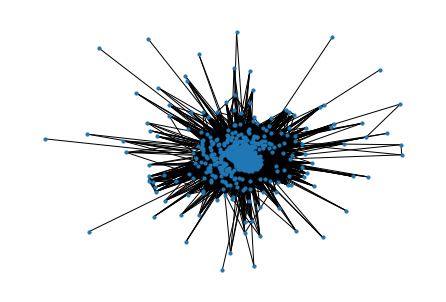

In [ ]:
nx.draw(G, node_size = 10)
plt.show()

As shown, there are some high density areas, indicating that reviewers have indeed reviewed the same businesses.